# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682.github.io/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from asgn1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **asgn1/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file asgn1/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from asgn1.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 1.850195
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 

We have not done any training so far, We have a random weight matrix. If we use Softmax on our random Weight Matrix, the chances of us getting an answer randomly is 1/10

ie, e^{correct_class_score}/(Sum of all e^{class_score}) = 0.1

So loss for one training example is like = -np.log(0.1)

So loss for n training example is like = (n * -np.log(0.1))/n

So loss is -np.log(0.1)





In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from asgn1.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.507346 analytic: -6.140382, relative error: 8.473626e-01
numerical: 0.138457 analytic: -0.453719, relative error: 1.000000e+00
numerical: -1.037274 analytic: -0.658257, relative error: 2.235386e-01
numerical: -3.270179 analytic: -3.074413, relative error: 3.085571e-02
numerical: -1.622595 analytic: -1.998937, relative error: 1.039180e-01
numerical: -11.678365 analytic: -2.847990, relative error: 6.078865e-01
numerical: -0.427236 analytic: -5.979097, relative error: 8.666208e-01
numerical: 1.884126 analytic: 2.968563, relative error: 2.234714e-01
numerical: 2.371177 analytic: -0.533942, relative error: 1.000000e+00
numerical: 5.289750 analytic: 0.459412, relative error: 8.401812e-01
numerical: -1.958627 analytic: 4.137894, relative error: 1.000000e+00
numerical: -0.287574 analytic: 0.927204, relative error: 1.000000e+00
numerical: -2.607198 analytic: 1.475621, relative error: 1.000000e+00
numerical: -0.578034 analytic: -0.956699, relative error: 2.467301e-01
numerical: 5.0

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from asgn1.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 1.850195e+00 computed in 0.366320s
vectorized loss: 2.313266e+00 computed in 0.018666s
Loss difference: 0.463071
Gradient difference: 72.964434


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from asgn1.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 4e-6,2e-5, 1e-4, 1e-3, 1e-2]
regularization_strengths = [5e4, 1e8, 1e2, 1e3, 1e1, 1e0]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
lr_rg_pairs = [(i, j) for i in learning_rates for j in regularization_strengths]
num_iterations = 1500
for lr, rg in lr_rg_pairs:
    softmax = Softmax()
    tic = time.time()
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rg, num_iters=num_iterations, verbose=True)
    toc = time.time()
    y_train_pred = softmax.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (training_accuracy, )
    y_val_pred = softmax.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (validation_accuracy, )
    results[(lr,rg)] = (training_accuracy,validation_accuracy ) 
    if(best_val<validation_accuracy):
        best_val = validation_accuracy
        best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 769.870242
iteration 100 / 1500: loss 282.300791
iteration 200 / 1500: loss 104.545484
iteration 300 / 1500: loss 39.557348
iteration 400 / 1500: loss 15.757238
iteration 500 / 1500: loss 7.089748
iteration 600 / 1500: loss 3.953126
iteration 700 / 1500: loss 2.723737
iteration 800 / 1500: loss 2.311651
iteration 900 / 1500: loss 2.270683
iteration 1000 / 1500: loss 2.184426
iteration 1100 / 1500: loss 2.116381
iteration 1200 / 1500: loss 2.146971
iteration 1300 / 1500: loss 2.103147
iteration 1400 / 1500: loss 2.091337
training accuracy: 0.328306
validation accuracy: 0.340000
iteration 0 / 1500: loss 1527241.394839


asgn1/classifiers/softmax.py:100: RuntimeWarning: divide by zero encountered in log
  loss = -1 * np.sum(np.log(M[range(len(M)),y]))


iteration 100 / 1500: loss inf


asgn1/classifiers/softmax.py:102: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5*reg* np.sum(W*W)
asgn1/classifiers/softmax.py:102: RuntimeWarning: overflow encountered in multiply
  loss += 0.5*reg* np.sum(W*W)


iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf


asgn1/classifiers/softmax.py:109: RuntimeWarning: overflow encountered in multiply
  dW += 0.5 * reg * 2 * W


iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1500: loss 7.168809
iteration 100 / 1500: loss 5.489550
iteration 200 / 1500: loss 4.854320
iteration 300 / 1500: loss 5.427609
iteration 400 / 1500: loss 4.932509
iteration 500 / 1500: loss 4.885174
iteration 600 / 1500: loss 4.443862
iteration 700 / 1500: loss 4.532328
iteration 800 / 1500: loss 4.605330
iteration 900 / 1500: loss 4.168285
iteration 1000 / 1500: loss 4.407867
iteration 1100 / 1500: loss 4.132884
iteration 1200 / 1500: loss 4.377700
iteration 1300 / 1500: loss 4.289064
iteration 1400 / 1500: loss 4.348988
training accuracy: 0.248000
validation accuracy: 0.24

asgn1/classifiers/softmax.py:93: RuntimeWarning: overflow encountered in subtract
  scores = scores - MaxArray_RowWise
asgn1/classifiers/softmax.py:93: RuntimeWarning: invalid value encountered in subtract
  scores = scores - MaxArray_RowWise


iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1500: loss 1549873.170775
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1500: loss 6.824602
iteration 100 / 1500: loss 37.523151
iteration 200 / 1500: loss 48.263951
iteration 300

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.359000


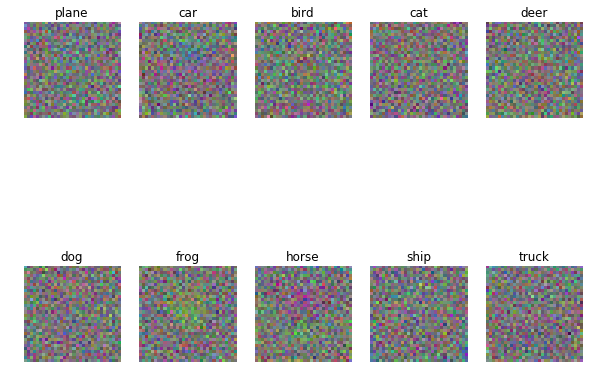

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])